# Importing libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from global_land_mask import is_land
from scipy.io import netcdf

In [2]:
DATA_FILE_DIR = './data_0.5/'

START_YEAR, END_YEAR = 2011, 2020

NUM_OF_YEARS = END_YEAR - START_YEAR

NUM_OF_MONTHS = 12

NUM_OF_DAYS = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31,}

LAT = 361

LON = 720

A function that opens netCDF file and read temperature variable and get the minimum temperature

In [3]:
def get_min_tmp(filename):
    file = netcdf.netcdf_file(filename, mmap=False)
    tmp = file.variables['T_MIN_L103_Pd'].data.copy()
    min_tmp = np.ndarray(tmp.shape[1:])

    for i in range(tmp.shape[1]):
        for j in range(tmp.shape[2]):
            min_tmp[i, j] = min(tmp[0, i, j], tmp[1, i, j], tmp[2, i, j], tmp[3, i, j])
    
    file.close()
    return min_tmp

Read 9 years of temperature data and take the average/minimum  
e.g. date '0417' min_tmp = 20110417_min_tmp + 20130417_min_tmp + ... + 2019_min_tmp

In [4]:
yearly_date_avg = {}
yearly_date_min = {}
for month in range(1, NUM_OF_MONTHS+1, 1):
    for day in range(1, NUM_OF_DAYS[month]+1, 1):
        date_tmps = np.zeros((NUM_OF_YEARS, LAT, LON))
        
        if month < 4: # if month<4, data is from 2012 to 2020
            for year in range(START_YEAR+1, END_YEAR+1):
                filename = DATA_FILE_DIR + '{}{:02d}{:02d}.nc'.format(year, month, day)
                assert os.path.isfile(filename), "File Not Found: '{}'".format(filename)
                date_tmps[year-START_YEAR-1] = get_min_tmp(filename)
        else: # if month>=4, data are from 2011 to 2019
            for year in range(START_YEAR, END_YEAR):
                filename = DATA_FILE_DIR + '{}{:02d}{:02d}.nc'.format(year, month, day)
                assert os.path.isfile(filename), "File Not Found: '{}'".format(filename)
                date_tmps[year-START_YEAR] = get_min_tmp(filename)
        
        yearly_date_avg['{:02d}{:02d}'.format(month, day)] = date_tmps.mean(axis=0)
        yearly_date_min['{:02d}{:02d}'.format(month, day)] = date_tmps.min(axis=0)

First add location columns--lat and lon  
Use `float16` type to keep df size small

In [5]:
filename = DATA_FILE_DIR + '20110401.nc'
file = netcdf.netcdf_file(filename, mmap=False)
lat = file.variables['lat'].data.copy()
lon = file.variables['lon'].data.copy()
file.close()

Generate a mask for land only

In [6]:
mask = np.ndarray((LAT, LON))
for i in range(LAT):
    mask[i] = is_land(lat[i], ((lon + 180) % 360) - 180) # need to convert 0-360 degree to -180-180 degree for computing

mask = mask.astype(bool)

Text(0, 0.5, 'Latitude')

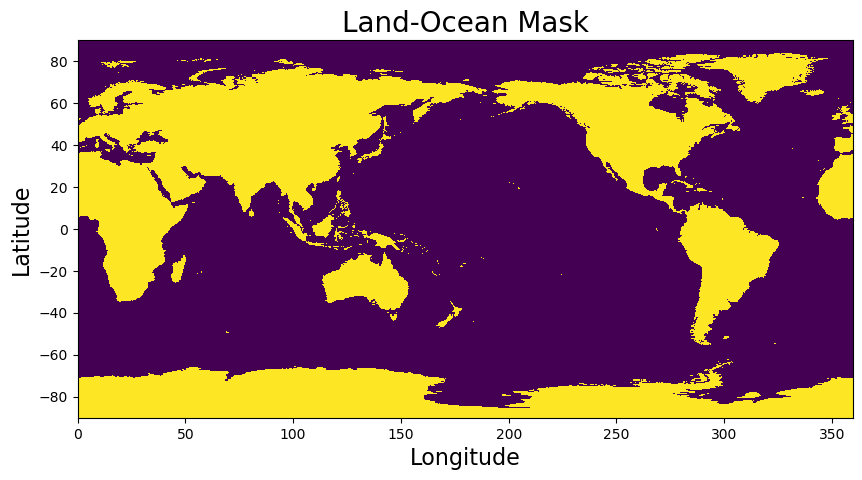

In [7]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
heatmap = ax.pcolormesh(lon, lat, mask)
ax.set_title('Land-Ocean Mask', size=20)
ax.set_xlabel('Longitude', size=16)
ax.set_ylabel('Latitude', size=16)

In [8]:
locations = np.zeros((mask.sum(dtype=int), 2))
count = 0
for i in range(LAT):
    for j in range(LON):
        if mask[i, j]:
            locations[count] = [lat[i], lon[j]]
            count += 1
df = pd.DataFrame(locations, columns=['lat', 'lon'], dtype='float16')

First add location columns--lat and lon  
Use `float16` type to keep df size small

In [11]:
for month in range(1, NUM_OF_MONTHS+1, 1):
    for day in range(1, NUM_OF_DAYS[month]+1, 1):
        date = '{:02d}{:02d}'.format(month, day)
        masked_tmp = np.ma.masked_where(mask==False, yearly_date_avg[date])
        masked_tmp = masked_tmp.compressed().astype('float16')
        df[date] = masked_tmp.reshape(-1, 1)

Save to a .csv file

In [12]:
df.to_csv('yearly_avg_05.csv', index=False)

# Below are trial for map

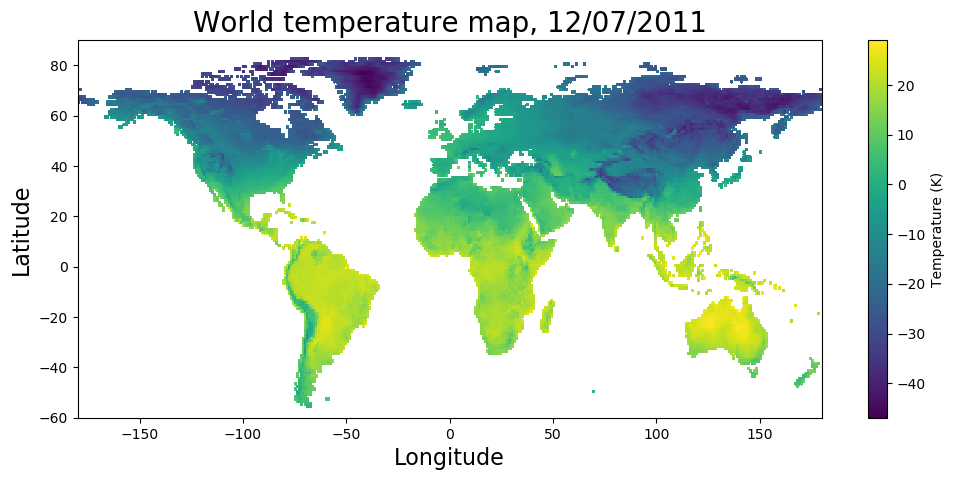

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
heatmap = ax.pcolormesh(lon, lat, np.ma.masked_where(mask==False, yearly_date_avg[date])-273.15)
ax.set_title('World temperature map, 12/07/2011', size=20)
ax.set_xlabel('Longitude', size=16)
ax.set_ylabel('Latitude', size=16)
fig.colorbar(heatmap, label='Temperature (K)')